In [1]:
import MDAnalysis as mda
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import connected_components

# The 'format="LAMMPSDUMP"' hint helps MDAnalysis parse the dump format
#u = mda.Universe("../final-model/bilayer.data", "full_1.lammpstrj", format="LAMMPSDUMP")


/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Heads = u.select_atoms("type 1 or type 8 or type 9")


NameError: name 'u' is not defined

In [3]:
def spherical_adjacency_same_type(coords, types, threshold_degrees=10.0):
    """
    Given Nx3 coords, an array of integer 'types' of length N,
    and a threshold in degrees, build an adjacency matrix for
    pairs that:
      1) have the same type,
      2) are within 'threshold_degrees' angle on the sphere.
    """
    n = coords.shape[0]
    if n < 2:
        return np.zeros((n, n), dtype=bool)

    # 1) Project each coordinate onto the unit sphere
    r = np.linalg.norm(coords, axis=1)
    unit_coords = coords / r[:, None]

    # 2) Dot products => cos(angle_ij)
    dot_mat = np.dot(unit_coords, unit_coords.T)
    # Clip to valid range to avoid numerical issues
    np.clip(dot_mat, -1.0, 1.0, out=dot_mat)
    
    # 3) Convert to angles in radians
    angles = np.arccos(dot_mat)
    thr = np.deg2rad(threshold_degrees)
    
    # 4) Same-type check
    same_type = (types[:, None] == types[None, :])
    
    # 5) adjacency: angle < thr AND same_type
    adjacency = (angles < thr) & same_type
    
    # Remove self-connections
    np.fill_diagonal(adjacency, False)

    return adjacency


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse_rdf_file(filename):
    """
    Parse an rdf.out file into blocks.
    Each block starts with a header line: "TimeStep Number-of-rows"
    followed by that many data rows (10 columns).
    Returns a dict: timestep -> DataFrame with columns:
      ["index","radius",
       "g(r1)","c(1)",
       "g(r2)","c(2)",
       "g(r3)","c(3)",
       "g(r4)","c(4)"]
    """
    blocks = {}
    with open(filename, "r") as f:
        lines = f.readlines()
        
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if not line or line.startswith("#"):
            i += 1
            continue
        
        tokens = line.split()
        if len(tokens) == 2:
            # Start of a block
            timestep = float(tokens[0])
            nrows = int(tokens[1])
            i += 1
            block_data = []
            for _ in range(nrows):
                if i >= len(lines):
                    break
                row_line = lines[i].strip()
                i += 1
                if row_line:
                    row_data = [float(tok) for tok in row_line.split()]
                    block_data.append(row_data)
            col_names = ["index", "radius", 
                         "g(r1)", "c(1)", 
                         "g(r2)", "c(2)", 
                         "g(r3)", "c(3)", 
                         "g(r4)", "c(4)"]
            df_block = pd.DataFrame(block_data, columns=col_names)
            blocks[timestep] = df_block
        else:
            i += 1
    return blocks

def plot_coord_numbers(rdf_dict, max_plots=20):
    """
    Plots up to `max_plots` timesteps from the parsed RDF data,
    focusing on coordination numbers c(1), c(2), c(3).
    
    - c(1) = unsaturated
    - c(2) = saturated
    - c(3) = cholesterol
    
    Creates 3 separate plots (figures), each overlaying lines for
    multiple timesteps.
    """
    if not rdf_dict:
        print("No RDF data found.")
        return

    # Sort available timesteps
    all_times = sorted(rdf_dict.keys())
    n_avail = len(all_times)

    # Pick up to max_plots times, spaced evenly through the set
    if n_avail > max_plots:
        idxs = np.linspace(0, n_avail - 1, max_plots, dtype=int)
        times_to_plot = [all_times[i] for i in idxs]
    else:
        times_to_plot = all_times

    # --- Plot c(1): unsaturated ---
    plt.figure()
    for t in times_to_plot:
        df = rdf_dict[t]
        radius = df["radius"].values
        c_unsat = df["c(1)"].values  # c(1) => unsaturated
        plt.plot(radius, c_unsat, label=f"t={t}")
    plt.xlabel("r (Å)")
    plt.ylabel("Coordination Number")
    plt.title("Unsaturated Coordination (c(1))")
    plt.legend()
    plt.show()

    # --- Plot c(2): saturated ---
    plt.figure()
    for t in times_to_plot:
        df = rdf_dict[t]
        radius = df["radius"].values
        c_sat = df["c(2)"].values  # c(2) => saturated
        plt.plot(radius, c_sat, label=f"t={t}")
    plt.xlabel("r (Å)")
    plt.ylabel("Coordination Number")
    plt.title("Saturated Coordination (c(2))")
    plt.legend()
    plt.show()

    # --- Plot c(3): cholesterol ---
    plt.figure()
    for t in times_to_plot:
        df = rdf_dict[t]
        radius = df["radius"].values
        c_chol = df["c(3)"].values  # c(3) => cholesterol
        plt.plot(radius, c_chol, label=f"t={t}")
    plt.xlabel("r (Å)")
    plt.ylabel("Coordination Number")
    plt.title("Cholesterol Coordination (c(3))")
    plt.legend()
    plt.show()


# =========================
# USAGE EXAMPLE:
# =========================
rdf_data = parse_rdf_file("rdf_1.out")
plot_coord_numbers(rdf_data, max_plots=20)


FileNotFoundError: [Errno 2] No such file or directory: 'rdf_1.out'

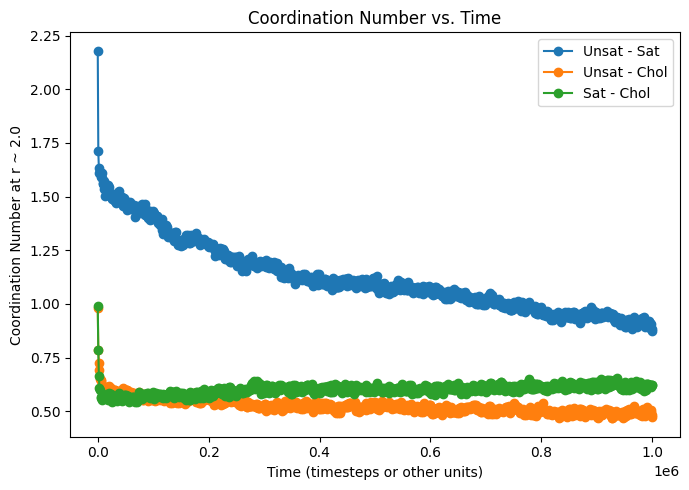

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse_rdf_file(filename):
    """
    Parse an rdf.out file into blocks.
    Each block starts with a header line: "TimeStep Number-of-rows"
    followed by that many data rows (10 columns).
    Returns a dict: timestep -> DataFrame with columns:
      ["index","radius",
       "g(r1)","c(1)",
       "g(r2)","c(2)",
       "g(r3)","c(3)",
       "g(r4)","c(4)"]
    """
    blocks = {}
    with open(filename, "r") as f:
        lines = f.readlines()
        
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if not line or line.startswith("#"):
            i += 1
            continue
        
        tokens = line.split()
        if len(tokens) == 2:
            # Start of a block
            timestep = float(tokens[0])
            nrows = int(tokens[1])
            i += 1
            block_data = []
            for _ in range(nrows):
                if i >= len(lines):
                    break
                row_line = lines[i].strip()
                i += 1
                if row_line:
                    row_data = [float(tok) for tok in row_line.split()]
                    block_data.append(row_data)
            col_names = ["index", "radius", 
                         "g(r1)", "c(1)", 
                         "g(r2)", "c(2)", 
                         "g(r3)", "c(3)", 
                         "g(r4)", "c(4)"]
            df_block = pd.DataFrame(block_data, columns=col_names)
            blocks[timestep] = df_block
        else:
            i += 1
    return blocks

def plot_coord_vs_time(rdf_dict, desired_radius=2.0):
    """
    For each timestep in rdf_dict, find the row whose 'radius' is closest
    to `desired_radius`. Then extract c(1), c(2), c(3) from that row.
    
    Plots time on x-axis vs. those coordination-number values on y-axis.
    
    c(1) => unsaturated, c(2) => saturated, c(3) => cholesterol.
    """
    # Sort timesteps
    all_times = sorted(rdf_dict.keys())
    if not all_times:
        print("No data found in rdf_dict.")
        return
    
    # We'll store c(1), c(2), c(3) from each time
    time_vals = []
    c1_vals = []
    c2_vals = []
    c3_vals = []

    for t in all_times:
        df = rdf_dict[t]
        # Find the index where radius is closest to 'desired_radius'
        radius_array = df["radius"].values
        idx = np.argmin(np.abs(radius_array - desired_radius))
        
        # Extract c(1), c(2), c(3) at that row
        c1 = df["c(1)"].iloc[idx]
        c2 = df["c(2)"].iloc[idx]
        c3 = df["c(3)"].iloc[idx]
        
        time_vals.append(t)
        c1_vals.append(c1)
        c2_vals.append(c2)
        c3_vals.append(c3)

    # Plot: time on X, c(1)/c(2)/c(3) on Y
    plt.figure(figsize=(7,5))
    plt.plot(time_vals, c1_vals, 'o-', label="Unsat - Sat")
    plt.plot(time_vals, c2_vals, 'o-', label="Unsat - Chol")
    plt.plot(time_vals, c3_vals, 'o-', label="Sat - Chol ")
    plt.xlabel("Time (timesteps or other units)")
    plt.ylabel(f"Coordination Number at r ~ {desired_radius}")
    plt.title("Coordination Number vs. Time")
    plt.legend()
    #plt.ylim(0.25,0.75)
    plt.tight_layout()
    plt.show()


# ======================
# USAGE EXAMPLE:
# ======================
rdf_data = parse_rdf_file("rdf_1.out")
plot_coord_vs_time(rdf_data, desired_radius=2.0)


Unsat–Sat c(1) 90% converged by: 683000.0
Unsat–Chol c(2) 90% converged by: 209000.0
Sat–Chol  c(3) 90% converged by: 3000.0


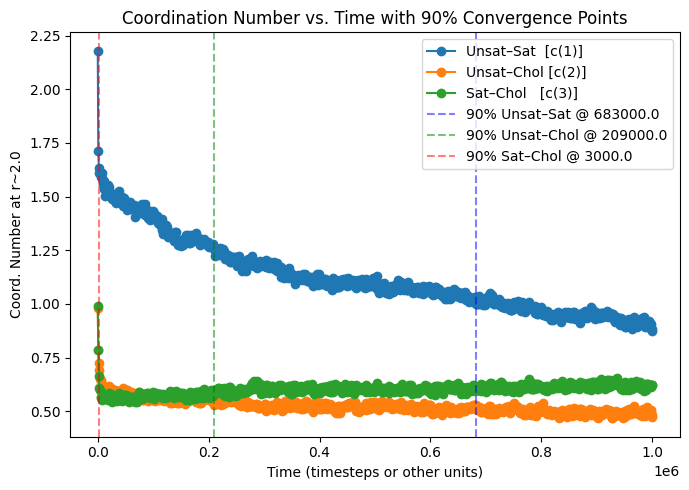

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse_rdf_file(filename):
    """
    Parse an rdf.out file into blocks.
    Each block starts with a header line: "TimeStep Number-of-rows"
    followed by that many data rows (10 columns).
    
    Returns a dict: { timestep -> DataFrame with columns:
      ["index","radius",
       "g(r1)","c(1)",
       "g(r2)","c(2)",
       "g(r3)","c(3)",
       "g(r4)","c(4)"] }
    """
    blocks = {}
    with open(filename, "r") as f:
        lines = f.readlines()
        
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if not line or line.startswith("#"):
            i += 1
            continue
        
        tokens = line.split()
        if len(tokens) == 2:
            # Start of a block
            timestep = float(tokens[0])
            nrows = int(tokens[1])
            i += 1
            block_data = []
            for _ in range(nrows):
                if i >= len(lines):
                    break
                row_line = lines[i].strip()
                i += 1
                if row_line:
                    row_data = [float(tok) for tok in row_line.split()]
                    block_data.append(row_data)
            col_names = ["index", "radius", 
                         "g(r1)", "c(1)", 
                         "g(r2)", "c(2)", 
                         "g(r3)", "c(3)", 
                         "g(r4)", "c(4)"]
            df_block = pd.DataFrame(block_data, columns=col_names)
            blocks[timestep] = df_block
        else:
            i += 1
    return blocks

def detect_90pct_convergence(time_array, values_array):
    """
    Returns the earliest time t* at which values_array has reached 90% 
    of its total net change from first to last point.
    
    This works whether the data is increasing or decreasing.
    We define total_change = values[-1] - values[0].
    We define 'target' = values[0] + 0.90 * total_change.
    
    If total_change > 0, we look for values_array[i] >= target.
    If total_change < 0, we look for values_array[i] <= target.
    """
    if len(time_array) < 2:
        return None
    
    y_start = values_array[0]
    y_final = values_array[-1]
    total_change = y_final - y_start
    target_90 = y_start + 0.9 * total_change
    
    if total_change > 0:
        # data goes up
        for i in range(len(values_array)):
            if values_array[i] >= target_90:
                return time_array[i]
    else:
        # data goes down or is flat
        for i in range(len(values_array)):
            if values_array[i] <= target_90:
                return time_array[i]
    return None  # never reached 90%

def plot_coord_vs_time_with_kink(rdf_dict, desired_radius=2.0):
    """
    1) For each timestep, find the row whose 'radius' is closest to `desired_radius`.
    2) Extract c(1), c(2), c(3) => Unsat-Sat, Unsat-Chol, Sat-Chol (based on your LAMMPS pairs).
    3) Plot each vs. time and detect when each hits 90% of its final net change.
    """
    # Sort timesteps
    all_times = sorted(rdf_dict.keys())
    if not all_times:
        print("No data found in rdf_dict.")
        return
    
    time_vals = []
    c1_vals = []
    c2_vals = []
    c3_vals = []

    # Collect data
    for t in all_times:
        df = rdf_dict[t]
        # Find the row with radius ~ desired_radius
        radius_array = df["radius"].values
        idx = np.argmin(np.abs(radius_array - desired_radius))
        
        c1 = df["c(1)"].iloc[idx]  # unsat-sat
        c2 = df["c(2)"].iloc[idx]  # unsat-chol
        c3 = df["c(3)"].iloc[idx]  # sat-chol
        
        time_vals.append(t)
        c1_vals.append(c1)
        c2_vals.append(c2)
        c3_vals.append(c3)

    time_vals = np.array(time_vals)
    c1_vals = np.array(c1_vals)
    c2_vals = np.array(c2_vals)
    c3_vals = np.array(c3_vals)

    # Detect 90% convergence for each line
    c1_kink = detect_90pct_convergence(time_vals, c1_vals)
    c2_kink = detect_90pct_convergence(time_vals, c2_vals)
    c3_kink = detect_90pct_convergence(time_vals, c3_vals)

    print(f"Unsat–Sat c(1) 90% converged by: {c1_kink if c1_kink else 'Never reached'}")
    print(f"Unsat–Chol c(2) 90% converged by: {c2_kink if c2_kink else 'Never reached'}")
    print(f"Sat–Chol  c(3) 90% converged by: {c3_kink if c3_kink else 'Never reached'}")

    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(time_vals, c1_vals, 'o-', label="Unsat–Sat  [c(1)]")
    plt.plot(time_vals, c2_vals, 'o-', label="Unsat–Chol [c(2)]")
    plt.plot(time_vals, c3_vals, 'o-', label="Sat–Chol   [c(3)]")

    # If we found kink times, let's draw a vertical line for each
    # (optional - to visualize on the plot)
    for kink_val, clr, txt in zip(
        [c1_kink, c2_kink, c3_kink],
        ['blue', 'green', 'red'],
        ["Unsat–Sat", "Unsat–Chol", "Sat–Chol"]):
        if kink_val is not None:
            plt.axvline(x=kink_val, color=clr, linestyle='--', alpha=0.5,
                        label=f"90% {txt} @ {kink_val}")

    plt.xlabel("Time (timesteps or other units)")
    plt.ylabel(f"Coord. Number at r~{desired_radius}")
    plt.title("Coordination Number vs. Time with 90% Convergence Points")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ======================
# USAGE EXAMPLE:
# ======================
# 1) Parse your data
# rdf_data = parse_rdf_file("rdf_1.out")
#
# 2) Plot + detect 90% convergence
plot_coord_vs_time_with_kink(rdf_data, desired_radius=2.0)
#
# It will print lines like:
#   Unsat–Sat c(1) 90% converged by: 700000
#   Unsat–Chol c(2) 90% converged by: ...
#   Sat–Chol  c(3) 90% converged by: ...
# and show a plot with optional vertical lines at those times.



=== Half‑way→final (mean ± 95 % CI) ===
c(1): top 105.2 % | mean 105.4 % | bot 105.7 %
c(2): top 100.5 % | mean 100.8 % | bot 101.2 %
c(3): top  99.6 % | mean  99.1 % | bot  98.4 %

=== Convergence at 500,000 steps ===
c(1):  94.1% complete of its total decay
c(2):  99.0% complete of its total decay
c(3): 100.0% complete of its total change


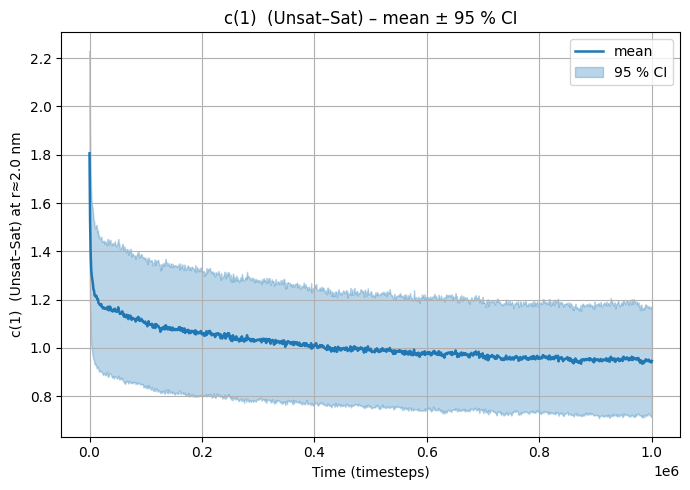

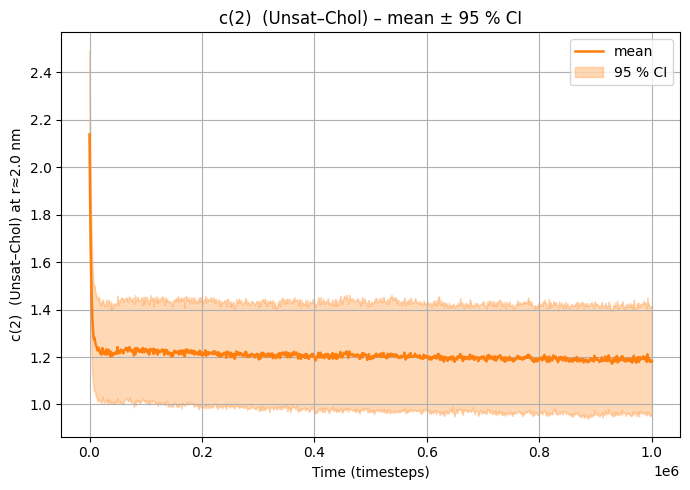

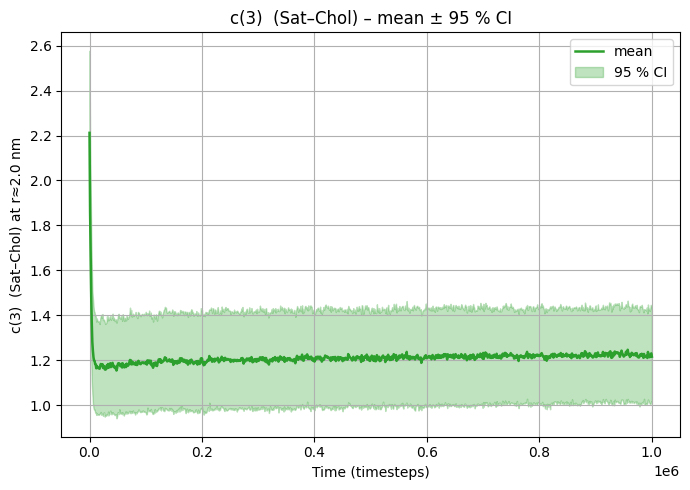

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

# ---------------- 1.  parsing (unchanged) -------------------------
def parse_rdf_file(filename):
    blocks = {}
    with open(filename, "r") as f:
        lines = f.readlines()
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if not line or line.startswith("#"):
            i += 1; continue
        toks = line.split()
        if len(toks) == 2:                          # new block
            ts, nrows = float(toks[0]), int(toks[1])
            i += 1
            rows = [[float(x) for x in lines[i+j].split()]
                     for j in range(nrows)]
            cols = ["index","radius","g(r1)","c(1)","g(r2)","c(2)",
                    "g(r3)","c(3)","g(r4)","c(4)"]
            blocks[ts] = pd.DataFrame(rows, columns=cols)
            i += nrows
        else:
            i += 1
    return blocks

# ---------------- 2.  helpers ------------------------------------
def extract_coord_vs_time(rdf_dict, r_probe=2.0):
    ts_sorted = np.array(sorted(rdf_dict))
    c1, c2, c3 = [], [], []
    for t in ts_sorted:
        df  = rdf_dict[t]
        idx = np.argmin(np.abs(df["radius"].values - r_probe))
        c1.append(df["c(1)"].iat[idx])
        c2.append(df["c(2)"].iat[idx])
        c3.append(df["c(3)"].iat[idx])
    return ts_sorted, np.array(c1), np.array(c2), np.array(c3)

def mean_ci(mat, z=1.96):
    mean = mat.mean(axis=0)
    sem  = mat.std(axis=0, ddof=1) / np.sqrt(mat.shape[0])
    ci   = z * sem
    return mean, ci

def halfway_percent(mean, ci):
    half = len(mean)//2
    def pct(arr):
        return 100.0*arr[half]/arr[-1] if arr[-1] else 0.0
    top = pct(mean+ci)
    mid = pct(mean)
    bot = pct(np.maximum(0, mean-ci))
    return top, mid, bot

def conv_ci_at_time(mats, times, t_target, z=1.96):
    """
    Compute confidence interval for convergence % at t_target
    across all replicates in mats.
    """
    conv_pcts = np.array([
        conv_pct_at_time(arr, times, t_target) for arr in mats
    ])
    mean = conv_pcts.mean()
    sem  = conv_pcts.std(ddof=1) / np.sqrt(len(conv_pcts))
    ci   = z * sem
    return mean, ci


def conv_pct_at_time(arr, times, t_target):
    """
    Given a 1D array `arr` sampled at monotonic `times`,
    return the percent completion at t_target of the total change
    from arr[0] → arr[-1].
    Clamped to [0,100].
    """
    idx = np.argmin(np.abs(times - t_target))
    start = arr[0]
    end   = arr[-1]
    # avoid divide‑by‑zero
    if end == start:
        return 100.0
    pct = 100.0 * (arr[idx] - start) / (end - start)
    # clamp between 0 and 100
    return float(np.clip(pct, 0.0, 100.0))

# ---------------- 3.  high‑level driver --------------------------
def analyse_rdf_coord_ci(file_list, r_probe=2.0, z=1.96,
                         cmap='tab10'):
    times    = None
    mats_c1, mats_c2, mats_c3 = [], [], []

    for fn in file_list:
        rdf = parse_rdf_file(fn)
        t, c1, c2, c3 = extract_coord_vs_time(rdf, r_probe)
        if times is None:
            times = t
        elif not np.array_equal(times, t):
            warnings.warn(f"Time grid mismatch in {fn}; "
                          "truncating to common part.")
            L = min(len(times), len(t))
            times  = times[:L]; c1 = c1[:L]; c2 = c2[:L]; c3 = c3[:L]
            mats_c1 = [x[:L] for x in mats_c1]
            mats_c2 = [x[:L] for x in mats_c2]
            mats_c3 = [x[:L] for x in mats_c3]
        mats_c1.append(c1); mats_c2.append(c2); mats_c3.append(c3)

    mats_c1 = np.vstack(mats_c1)
    mats_c2 = np.vstack(mats_c2)
    mats_c3 = np.vstack(mats_c3)

    # ---- stats ---------------------------------------------------
    mean1, ci1 = mean_ci(mats_c1, z)
    mean2, ci2 = mean_ci(mats_c2, z)
    mean3, ci3 = mean_ci(mats_c3, z)

    # ---- halfway percentages ------------------------------------
    pct1 = halfway_percent(mean1, ci1)
    pct2 = halfway_percent(mean2, ci2)
    pct3 = halfway_percent(mean3, ci3)

    print("\n=== Half‑way→final (mean ± 95 % CI) ===")
    for lab, p in zip(("c(1)", "c(2)", "c(3)"), (pct1, pct2, pct3)):
        print(f"{lab:4s}: top {p[0]:5.1f} % | mean {p[1]:5.1f} % | "
              f"bot {p[2]:5.1f} %")
        

     # ---- new: convergence % at 500k using only the mean curves ----
    t_check = 500_000
    conv1, ci_conv1 = conv_ci_at_time(mats_c1, times, t_check, z)
    conv2, ci_conv2 = conv_ci_at_time(mats_c2, times, t_check, z)
    conv3, ci_conv3 = conv_ci_at_time(mats_c3, times, t_check, z)

    print(f"\n=== Convergence at {t_check:,} steps (mean ± 95 % CI) ===")
    print(f"c(1): {conv1:5.1f} ± {ci_conv1:4.1f} % complete")
    print(f"c(2): {conv2:5.1f} ± {ci_conv2:4.1f} % complete")
    print(f"c(3): {conv3:5.1f} ± {ci_conv3:4.1f} % complete")


    # ---- plotting ------------------------------------------------
    def plot_band(mean, ci, title, colour):
        plt.figure(figsize=(7,5))
        plt.plot(times, mean, lw=1.8, color=colour,
                 label="mean")
        plt.fill_between(times, np.maximum(0, mean-ci), mean+ci,
                         color=colour, alpha=0.3, label="95 % CI")
        plt.xlabel("Time (timesteps)")
        plt.ylabel(f"{title} at r≈{r_probe} nm")
        plt.title(f"{title} – mean ± 95 % CI")
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    plot_band(mean1, ci1, "c(1)  (Unsat–Sat)",   "tab:blue")
    plot_band(mean2, ci2, "c(2)  (Unsat–Chol)", "tab:orange")
    plot_band(mean3, ci3, "c(3)  (Sat–Chol)",   "tab:green")


# ---------------- 4.  run ----------------------------------------
if __name__ == "__main__":
    RDF_FILES = [
        "rdf_adapt_bilayer_chol30_equal.out",
        "rdf_adapt_bilayer_chol30_u30.out",
        "rdf_adapt_bilayer_chol30_u70.out",
        "rdf_adapt_bilayer_chol40_equal.out",
        "rdf_adapt_bilayer_chol40_u30.out",
        "rdf_adapt_bilayer_chol40_u70.out",
        "rdf_adapt_bilayer_chol50_equal.out",
        "rdf_adapt_bilayer_chol50_u30.out",
        "rdf_adapt_bilayer_chol50_u70.out",
    ]
    analyse_rdf_coord_ci(RDF_FILES, r_probe=2.0, z=1.96)



Number of analyzed frames: 101
Halfway index: 50, which corresponds to frame: 500
Final index: 100, which corresponds to frame: 1000

For type=1, halfway = 1087 vs. final=1602 => 67.9%
For type=8, halfway = 3373 vs. final=3831 => 88.0%


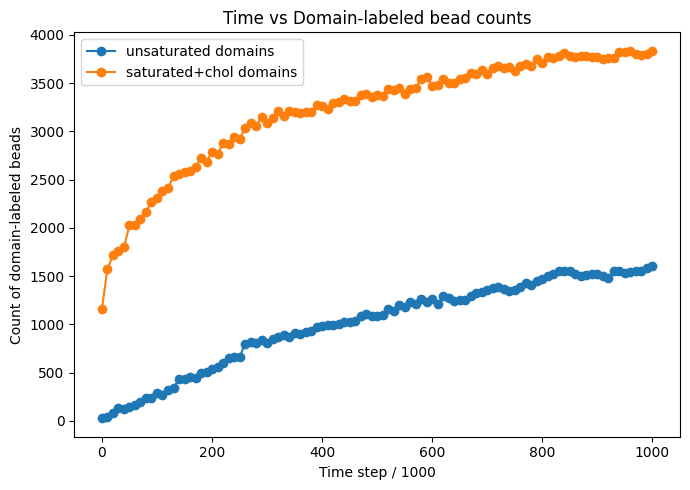

In [17]:
import MDAnalysis as mda
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

def local_composition_domain(u, selection_str="type 1 or type 8 or type 9",
                             cutoff=3.0, fraction_threshold=0.7, 
                             skip=1, max_frames=50):
    ag = u.select_atoms(selection_str)
    if ag.n_atoms == 0:
        print("No atoms selected!")
        return {}
    
    frame_results = {}
    nframes_total = len(u.trajectory)
    stride = max(1, nframes_total // max_frames) if skip is None else skip
    
    frame_count = 0
    for fi, ts in enumerate(u.trajectory[::stride]):
        coords = ag.positions
        types  = ag.types
        tree = cKDTree(coords)
        
        domain_counts = {}
        
        for i in range(len(coords)):
            # Map type=9 to 8 for counting
            my_type = types[i]
            if my_type == '9':
                my_type = '8'
            
            neighbor_idxs = tree.query_ball_point(coords[i], cutoff)
            neighbor_types = [t if t != '9' else '8' for t in types[neighbor_idxs]]
            
            same_type_count = np.sum(np.array(neighbor_types) == my_type)
            total_count = len(neighbor_idxs)
            
            frac_same = same_type_count / total_count if total_count > 0 else 0.0
            
            if frac_same >= fraction_threshold:
                if my_type not in domain_counts:
                    domain_counts[my_type] = 0
                domain_counts[my_type] += 1
        
        frame_results[ts.frame] = domain_counts
        
        frame_count += 1
        if frame_count >= max_frames:
            break
    
    return frame_results

def plot_domain_counts_and_halfway(frame_results):
    """
    Plots the domain-labeled counts vs time 
    AND prints how much of final value is reached at halfway mark.
    """
    if not frame_results:
        print("No data to plot.")
        return
    
    frames_sorted = sorted(frame_results.keys())
    all_types = set()
    for f in frames_sorted:
        all_types.update(frame_results[f].keys())
    all_types = sorted(all_types)
    
    time_vals = []
    counts_per_type = {t: [] for t in all_types}
    
    for f in frames_sorted:
        time_vals.append(f)
        dcounts = frame_results[f]
        for t in all_types:
            counts_per_type[t].append(dcounts.get(t, 0))

    # --- Print how much is achieved at "halfway" frame ---
    n = len(time_vals)
    if n > 1:
        half_idx = n // 2  # integer index for halfway in the list
        half_frame = time_vals[half_idx]
        final_frame = time_vals[-1]
        print(f"\nNumber of analyzed frames: {n}")
        print(f"Halfway index: {half_idx}, which corresponds to frame: {half_frame}")
        print(f"Final index: {n-1}, which corresponds to frame: {final_frame}\n")

        for t in all_types:
            final_val = counts_per_type[t][-1]
            half_val = counts_per_type[t][half_idx]
            if final_val != 0:
                pct = 100.0 * half_val / final_val
            else:
                pct = 0.0
            print(f"For type={t}, halfway = {half_val} vs. final={final_val} => {pct:.1f}%")

    # --- Plot ---
    plt.figure(figsize=(7,5))
    for t in all_types:
        if t == '1':
            t_label = 'unsaturated domains'
        else:
            t_label = 'saturated+chol domains'
        plt.plot(time_vals, counts_per_type[t], 'o-', label=f"{t_label}")
    
    plt.xlabel("Time step / 1000")
    plt.ylabel("Count of domain-labeled beads")
    plt.title("Time vs Domain-labeled bead counts")
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================
# Example usage
# =========================
# u = mda.Universe("bilayer.data", "full_1.lammstrj", format="LAMMPSDUMP")
results = local_composition_domain(
     u,
     selection_str="type 1 or type 8 or type 9",
     cutoff=3.0,
     fraction_threshold=0.70,
     skip=10,
     max_frames=500
 )
plot_domain_counts_and_halfway(results)
#
# This will both show the final plot AND print lines like:
#   "For type=1, halfway=..., final=..., => X%"


→ using topology: bilayer_chol30_equal.data


/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:667: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt


full_traj_adapt_bilayer_chol30_equal  type 1  half/final =  80.0 %
full_traj_adapt_bilayer_chol30_equal  type 8  half/final =  93.8 %
→ using topology: bilayer_chol30_u30.data
full_traj_adapt_bilayer_chol30_u30   type 1  half/final =  39.8 %
full_traj_adapt_bilayer_chol30_u30   type 8  half/final =  98.4 %
→ using topology: bilayer_chol30_u70.data
full_traj_adapt_bilayer_chol30_u70   type 1  half/final =  81.8 %
full_traj_adapt_bilayer_chol30_u70   type 8  half/final =  87.9 %
→ using topology: bilayer_chol40_equal.data
full_traj_adapt_bilayer_chol40_equal  type 1  half/final =  62.6 %
full_traj_adapt_bilayer_chol40_equal  type 8  half/final =  96.7 %
→ using topology: bilayer_chol40_u30.data
full_traj_adapt_bilayer_chol40_u30   type 1  half/final =  87.0 %
full_traj_adapt_bilayer_chol40_u30   type 8  half/final = 100.4 %
→ using topology: bilayer_chol40_u70.data
full_traj_adapt_bilayer_chol40_u70   type 1  half/final =  77.2 %
full_traj_adapt_bilayer_chol40_u70   type 8  half/final = 

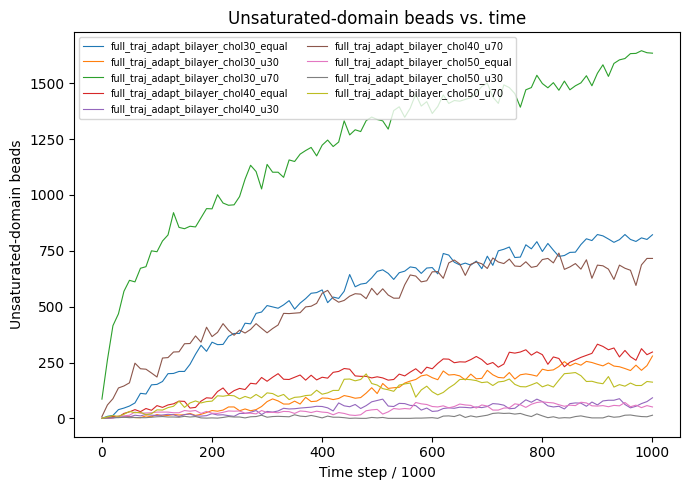

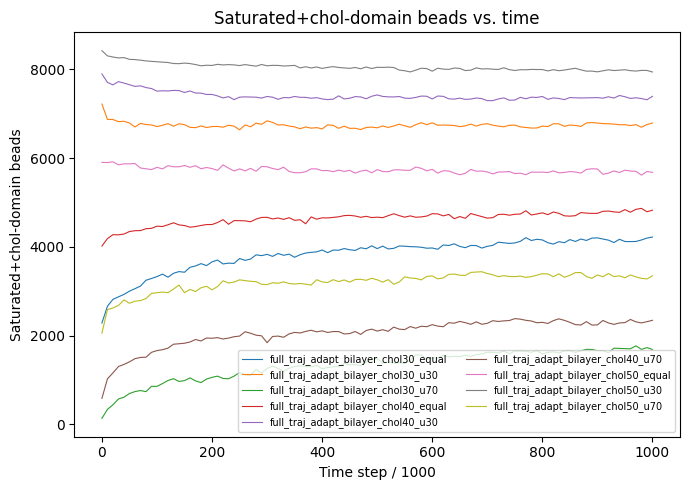

In [5]:
import MDAnalysis as mda
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# ------------------------------------------------------------------
# 1.  LOCAL‐COMPOSITION ANALYSIS  (your original routine, unchanged)
# ------------------------------------------------------------------
def local_composition_domain(u, selection_str="type 1 or type 8 or type 9",
                             cutoff=3.0, fraction_threshold=0.7,
                             skip=1, max_frames=50):
    ag = u.select_atoms(selection_str)
    if ag.n_atoms == 0:
        print("No atoms selected!")
        return {}
    
    frame_results = {}
    nframes_total = len(u.trajectory)
    stride = max(1, nframes_total // max_frames) if skip is None else skip

    frame_count = 0
    for ts in u.trajectory[::stride]:
        coords = ag.positions
        types  = ag.types
        tree   = cKDTree(coords)

        domain_counts = {}

        for i in range(len(coords)):
            my_type = types[i]
            if my_type == '9':                     # map 9 → 8
                my_type = '8'
            neigh_idx   = tree.query_ball_point(coords[i], cutoff)
            neigh_types = [t if t != '9' else '8' for t in types[neigh_idx]]

            same = np.sum(np.array(neigh_types) == my_type)
            frac_same = same / len(neigh_idx) if neigh_idx else 0.0

            if frac_same >= fraction_threshold:
                domain_counts[my_type] = domain_counts.get(my_type, 0) + 1

        frame_results[ts.frame] = domain_counts
        frame_count += 1
        if frame_count >= max_frames:
            break

    return frame_results


# ------------------------------------------------------------------
# 2.  LIGHT‑WEIGHT WRAPPER UTILITIES
# ------------------------------------------------------------------
def _extract_counts(frame_results):
    """Return time, type‑1 counts, type‑8 counts (9 is already folded in)."""
    frames = sorted(frame_results)
    c1, c8 = [], []
    for f in frames:
        d = frame_results[f]
        c1.append(d.get('1', 0))
        c8.append(d.get('8', 0))
    return np.array(frames), np.array(c1), np.array(c8)


def _plot_per_type(all_data, type_key, y_label):
    """Draw one figure containing one curve per trajectory."""
    plt.figure(figsize=(7, 5))
    for i, (fname, d) in enumerate(all_data.items()):
        plt.plot(d["time"], d[type_key],
                 label=Path(fname).stem,
                 lw=0.8,
                 color=plt.get_cmap("tab10")(i % 10))
    plt.xlabel("Time step / 1000")
    plt.ylabel(y_label)
    plt.title(f"{y_label} vs. time")
    plt.legend(fontsize=7, ncol=2)
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------
# 3.  HIGH‑LEVEL DRIVER (auto‑select .data for each traj)
# ------------------------------------------------------------------
def analyse_domain_growth(trajectory_files,
                          selection_str="type 1 or type 8 or type 9",
                          cutoff=3.0, fraction_threshold=0.7,
                          skip=10, max_frames=500):

    results = {}
    pct_halfway = defaultdict(list)

    for traj in trajectory_files:
        stem = Path(traj).stem
        prefix = "full_traj_adapt_"
        if stem.startswith(prefix):
            data_stem = stem[len(prefix):]
        else:
            idx = stem.find("bilayer_")
            if idx != -1:
                data_stem = stem[idx:]
            else:
                raise ValueError(f"Cannot parse data‐file name from `{traj}`")
        data_file = data_stem + ".data"
        print(f"→ using topology: {data_file}")

        u = mda.Universe(data_file, traj, format="LAMMPSDUMP")

        fr = local_composition_domain(
            u,
            selection_str=selection_str,
            cutoff=cutoff,
            fraction_threshold=fraction_threshold,
            skip=skip,
            max_frames=max_frames
        )
        if not fr:
            continue

        t, c1, c8 = _extract_counts(fr)
        results[traj] = {"time": t, "1": c1, "8": c8}

        for typ, vec in (('1', c1), ('8', c8)):
            if len(vec) > 1 and vec[-1] != 0:
                pct = 100.0 * vec[len(vec)//2] / vec[-1]
            else:
                pct = 0.0
            pct_halfway[typ].append(pct)
            print(f"{Path(traj).stem:35s}  type {typ}  half/final = {pct:5.1f} %")

    # summary statistics
    for typ, arr in pct_halfway.items():
        arr = np.asarray(arr)
        if arr.size:
            mean, sd = arr.mean(), arr.std(ddof=1)
            print(f"Type {typ}: ⟨half/final⟩ = {mean:.1f} ± {sd:.1f} %  (n={len(arr)})")

    # plotting
    _plot_per_type(results, "1", "Unsaturated‑domain beads")
    _plot_per_type(results, "8", "Saturated+chol‑domain beads")


# ------------------------------------------------------------------
# 4.  CALL IT
# ------------------------------------------------------------------
if __name__ == "__main__":
    trjs = [
        "full_traj_adapt_bilayer_chol30_equal.lammpstrj",
        "full_traj_adapt_bilayer_chol30_u30.lammpstrj",
        "full_traj_adapt_bilayer_chol30_u70.lammpstrj",
        "full_traj_adapt_bilayer_chol40_equal.lammpstrj",
        "full_traj_adapt_bilayer_chol40_u30.lammpstrj",
        "full_traj_adapt_bilayer_chol40_u70.lammpstrj",
        "full_traj_adapt_bilayer_chol50_equal.lammpstrj",
        "full_traj_adapt_bilayer_chol50_u30.lammpstrj",
        "full_traj_adapt_bilayer_chol50_u70.lammpstrj",
    ]

    analyse_domain_growth(
        trajectory_files=trjs,
        selection_str="type 1 or type 8 or type 9",
        cutoff=3.0,
        fraction_threshold=0.70,
        skip=10,
        max_frames=500
    )


/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:667: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt



=== Half‑way to final (mean ± 95 % CI) ===
Type 1   : top  79.3 % | mean  76.6 % | bot  56.8 %
Type 8/9 : top  99.6 % | mean  98.1 % | bot  95.2 %



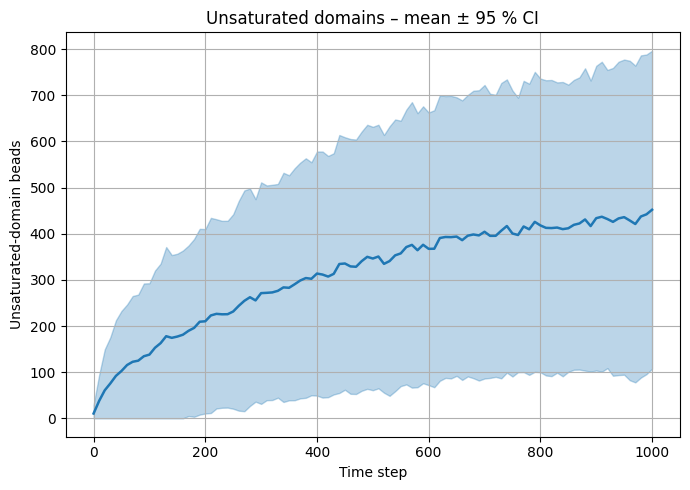

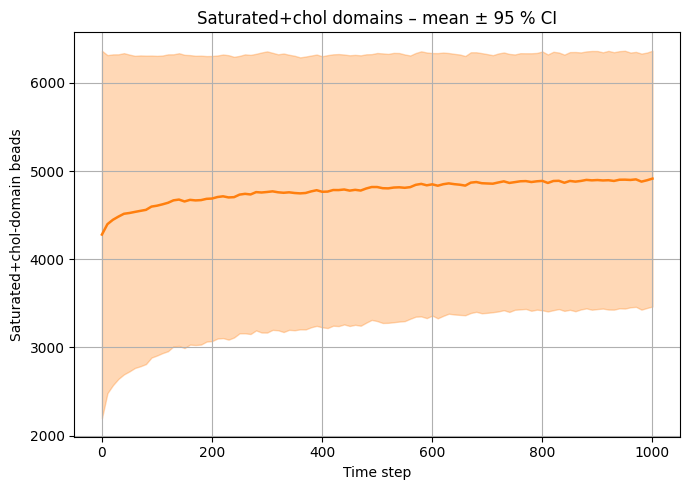

In [8]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from pathlib import Path
import warnings

# ‑‑‑‑‑ PARAMETERS you might tweak ‑‑‑‑‑#
TRAJ_FILES = [
    "full_traj_adapt_bilayer_chol30_equal.lammpstrj",
    "full_traj_adapt_bilayer_chol30_u30.lammpstrj",
    "full_traj_adapt_bilayer_chol30_u70.lammpstrj",
    "full_traj_adapt_bilayer_chol40_equal.lammpstrj",
    "full_traj_adapt_bilayer_chol40_u30.lammpstrj",
    "full_traj_adapt_bilayer_chol40_u70.lammpstrj",
    "full_traj_adapt_bilayer_chol50_equal.lammpstrj",
    "full_traj_adapt_bilayer_chol50_u30.lammpstrj",
    "full_traj_adapt_bilayer_chol50_u70.lammpstrj",
]
CUTOFF              = 3.0
FRACTION_THRESHOLD  = 0.70
SKIP_FRAMES         = 10
MAX_FRAMES_ANALYSED = 500
Z_95                = 1.96     # two‑sided 95 % confidence

# ------------------------------------------------------------------
# 1.  LOCAL‑COMPOSITION ANALYSIS  (unchanged)
# ------------------------------------------------------------------
def local_composition_domain(u, selection_str="type 1 or type 8 or type 9",
                             cutoff=3.0, fraction_threshold=0.7,
                             skip=1, max_frames=50):
    ag = u.select_atoms(selection_str)
    frame_results = {}
    stride = max(1, len(u.trajectory) // max_frames) if skip is None else skip

    for idx, ts in enumerate(u.trajectory[::stride]):
        coords = ag.positions
        types  = ag.types
        tree   = cKDTree(coords)
        counts = {}

        for i, typ in enumerate(types):
            # fold type ‘9’ into ‘8’
            typ = "8" if typ == "9" else typ

            nbr = tree.query_ball_point(coords[i], cutoff)
            neigh_types = [t if t != "9" else "8" for t in types[nbr]]

            if len(neigh_types) > 0 and (neigh_types.count(typ) / len(neigh_types)) >= fraction_threshold:
                counts[typ] = counts.get(typ, 0) + 1

        frame_results[ts.frame] = counts
        if idx + 1 >= max_frames:
            break

    return frame_results

# ------------------------------------------------------------------
# 2.  DRIVER WITH MEAN ± CI  (now infers .data per traj)
# ------------------------------------------------------------------
def analyse_domain_growth_ci(traj_files,
                             cutoff=3.0, fraction_threshold=0.7,
                             skip=1, max_frames=50,
                             z_score=1.96):

    times, c1_mat, c8_mat = None, [], []

    for fn in traj_files:
        # infer matching .data topology from the trajectory name
        stem = Path(fn).stem
        prefix = "full_traj_adapt_"
        if stem.startswith(prefix):
            data_stem = stem[len(prefix):]
        else:
            idx = stem.find("bilayer_")
            if idx != -1:
                data_stem = stem[idx:]
            else:
                raise ValueError(f"Cannot parse data‑file name from `{fn}`")
        topo = data_stem + ".data"

        # load and analyse
        u = mda.Universe(topo, fn, format="LAMMPSDUMP")
        fr = local_composition_domain(u,
                                      cutoff=cutoff,
                                      fraction_threshold=fraction_threshold,
                                      skip=skip,
                                      max_frames=max_frames)
        if not fr:
            warnings.warn(f"No data extracted from {fn}")
            continue

        # build time‐series for this traj
        t_sorted = np.array(sorted(fr))
        c1 = np.array([fr[f].get("1", 0) for f in t_sorted])
        c8 = np.array([fr[f].get("8", 0) for f in t_sorted])

        # align on a common time grid
        if times is None:
            times = t_sorted
        elif not np.array_equal(times, t_sorted):
            warnings.warn(f"Time grid mismatch in {fn}; truncating to common overlap.")
            L = min(times.size, t_sorted.size)
            times = times[:L]
            c1 = c1[:L]
            c8 = c8[:L]
            c1_mat = [x[:L] for x in c1_mat]
            c8_mat = [x[:L] for x in c8_mat]

        c1_mat.append(c1)
        c8_mat.append(c8)

    # stack into shape (n_traj, n_time)
    c1_mat = np.vstack(c1_mat)
    c8_mat = np.vstack(c8_mat)
    n_traj = c1_mat.shape[0]

    # compute mean ± CI
    def mean_ci(mat):
        mean = mat.mean(axis=0)
        sem  = mat.std(axis=0, ddof=1) / np.sqrt(n_traj)
        ci   = z_score * sem
        return mean, ci

    c1_mean, c1_ci = mean_ci(c1_mat)
    c8_mean, c8_ci = mean_ci(c8_mat)

    # halfway → final percentages
    half_idx = len(times) // 2
    def pct_half(mean, ci):
        upper = mean + ci
        lower = np.maximum(0, mean - ci)
        def _pct(arr):
            return 100.0 * arr[half_idx] / arr[-1] if arr[-1] else 0.0
        return _pct(upper), _pct(mean), _pct(lower)

    p1_top, p1_mid, p1_bot = pct_half(c1_mean, c1_ci)
    p8_top, p8_mid, p8_bot = pct_half(c8_mean, c8_ci)

    print("\n=== Half‑way to final (mean ± 95 % CI) ===")
    print(f"Type 1   : top {p1_top:5.1f} % | mean {p1_mid:5.1f} % | bot {p1_bot:5.1f} %")
    print(f"Type 8/9 : top {p8_top:5.1f} % | mean {p8_mid:5.1f} % | bot {p8_bot:5.1f} %\n")

    # plotting helpers
    def plot_band(mean, ci, label, colour):
        plt.plot(times, mean, lw=1.8, label=label, color=colour)
        plt.fill_between(times,
                         np.maximum(0, mean - ci),
                         mean + ci,
                         alpha=0.3,
                         color=colour)

    # Unsaturated domains (type 1)
    plt.figure(figsize=(7,5))
    plot_band(c1_mean, c1_ci, "mean Unsat domains", "tab:blue")
    plt.xlabel("Time step")
    plt.ylabel("Unsaturated‑domain beads")
    plt.title("Unsaturated domains – mean ± 95 % CI")
    plt.grid(True); plt.tight_layout(); plt.show()

    # Saturated+chol domains (type 8/9)
    plt.figure(figsize=(7,5))
    plot_band(c8_mean, c8_ci, "mean Sat+Chol domains", "tab:orange")
    plt.xlabel("Time step")
    plt.ylabel("Saturated+chol‑domain beads")
    plt.title("Saturated+chol domains – mean ± 95 % CI")
    plt.grid(True); plt.tight_layout(); plt.show()


# ------------------------------------------------------------------
# 3.  RUN
# ------------------------------------------------------------------
if __name__ == "__main__":
    analyse_domain_growth_ci(
        traj_files           = TRAJ_FILES,
        cutoff               = CUTOFF,
        fraction_threshold   = FRACTION_THRESHOLD,
        skip                 = SKIP_FRAMES,
        max_frames           = MAX_FRAMES_ANALYSED,
        z_score              = Z_95,
    )


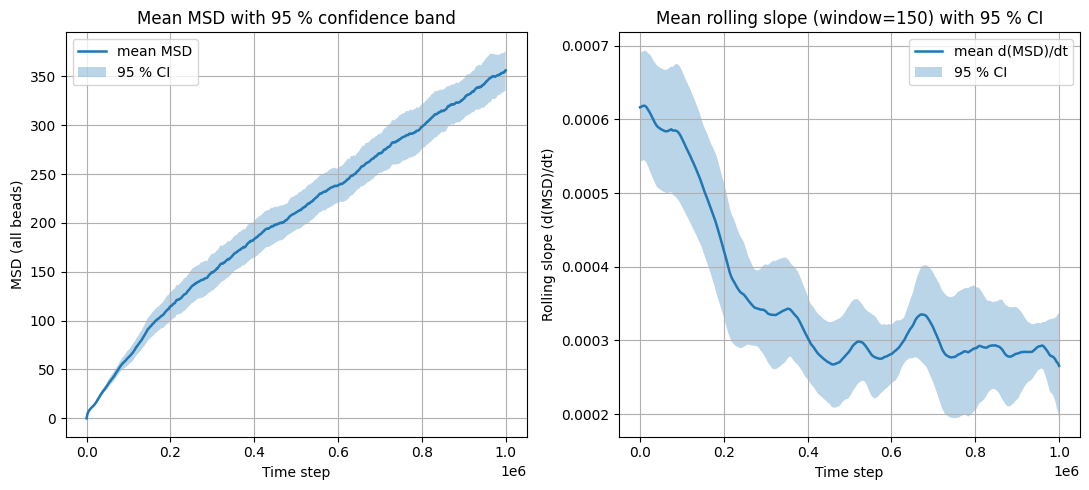

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------------------------
# 1. PARAMETERS you may want to tweak once
# -------------------------------------------------------------
FILES = [
    "msd_adapt_bilayer_chol30_equal.out",
    "msd_adapt_bilayer_chol30_u30.out",
    "msd_adapt_bilayer_chol30_u70.out",
    "msd_adapt_bilayer_chol40_equal.out",
    "msd_adapt_bilayer_chol40_u30.out",
    "msd_adapt_bilayer_chol40_u70.out",
    "msd_adapt_bilayer_chol50_equal.out",
    "msd_adapt_bilayer_chol50_u30.out",
    "msd_adapt_bilayer_chol50_u70.out",
]
WINDOW = 150        # points for rolling‐slope fit
CONF_Z = 1.96       # 95 % two‑sided z‑score

# -------------------------------------------------------------
# 2. util: rolling slope
# -------------------------------------------------------------
def rolling_slope(x, y, window=101):
    half = window // 2
    n    = len(x)
    slopes = np.empty(n)
    for i in range(n):
        l = max(0, i-half)
        r = min(n, i+half+1)            # +1 -> include right edge
        slope, _ = np.polyfit(x[l:r], y[l:r], 1)
        slopes[i] = slope
    return slopes

# -------------------------------------------------------------
# 3. read every file, compute rolling slopes, store in arrays
# -------------------------------------------------------------
times, msd_matrix, slope_matrix = None, [], []

for fn in FILES:
    df = pd.read_csv(fn, sep=r"\s+", comment="#", header=None,
                     names=["TimeStep", "v_msd_all_val",
                            "v_msd_1_val", "v_msd_8_val", "v_msd_9_val"])
    
    t   = df["TimeStep"].values
    y   = df["v_msd_all_val"].values
    
    if times is None:
        times = t
    else:
        # basic sanity check
        if not np.array_equal(times, t):
            raise ValueError(f"Time grid mismatch in {fn}")

    msd_matrix.append(y)
    slope_matrix.append(rolling_slope(t, y, window=WINDOW))

msd_matrix   = np.vstack(msd_matrix)      # shape (n_files, n_time)
slope_matrix = np.vstack(slope_matrix)

n_files = msd_matrix.shape[0]

# -------------------------------------------------------------
# 4. statistics: mean and 95 % CI  (mean ± z * σ/√n)
# -------------------------------------------------------------
def mean_ci(arr):
    mean = arr.mean(axis=0)
    sem  = arr.std(axis=0, ddof=1) / np.sqrt(n_files)
    ci   = CONF_Z * sem
    return mean, ci

msd_mean,   msd_ci   = mean_ci(msd_matrix)
slope_mean, slope_ci = mean_ci(slope_matrix)

# -------------------------------------------------------------
# 5. plots
# -------------------------------------------------------------
plt.figure(figsize=(11, 5))

# ---- MSD ------------------------------------------------------
plt.subplot(1, 2, 1)
plt.plot(times, msd_mean, lw=1.8, label="mean MSD")
plt.fill_between(times, msd_mean-msd_ci, msd_mean+msd_ci,
                 alpha=0.3, label="95 % CI")
plt.xlabel("Time step")
plt.ylabel("MSD (all beads)")
plt.title("Mean MSD with 95 % confidence band")
plt.grid(True)
plt.legend()

# ---- rolling derivative --------------------------------------
plt.subplot(1, 2, 2)
plt.plot(times, slope_mean, lw=1.8, label="mean d(MSD)/dt")
plt.fill_between(times, slope_mean-slope_ci, slope_mean+slope_ci,
                 alpha=0.3, label="95 % CI")
plt.xlabel("Time step")
plt.ylabel("Rolling slope (d(MSD)/dt)")
plt.title(f"Mean rolling slope (window={WINDOW}) with 95 % CI")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



=== Convergence at 500000 steps ===
  D(500,000)   = 2.857e-04 ± 6.2e-05
  D_asymptotic    = 2.857e-04 ± 5.6e-05
  Relative error  = 0.0 %
  95 % CIs overlap? True


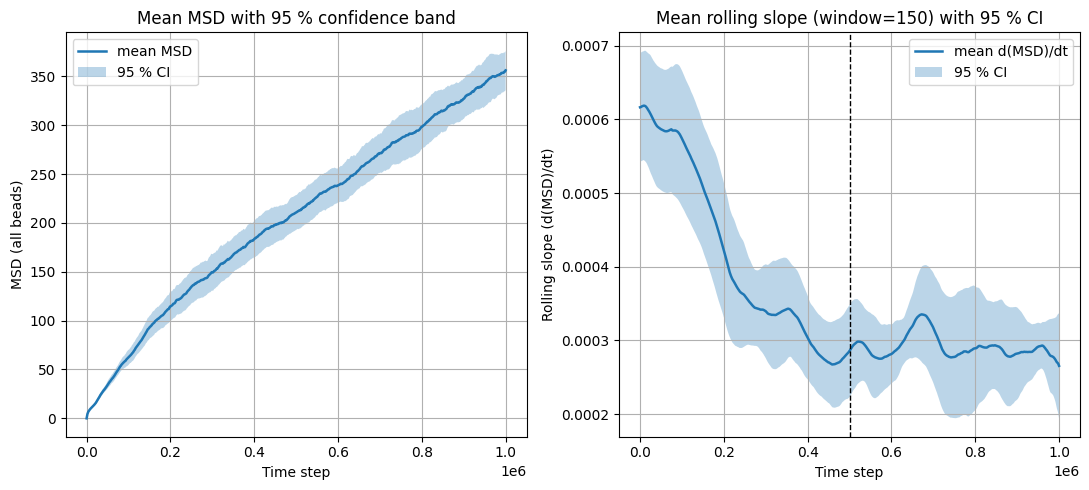

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------------------------
# 1. PARAMETERS you may want to tweak once
# -------------------------------------------------------------
FILES = [
    "msd_adapt_bilayer_chol30_equal.out",
    "msd_adapt_bilayer_chol30_u30.out",
    "msd_adapt_bilayer_chol30_u70.out",
    "msd_adapt_bilayer_chol40_equal.out",
    "msd_adapt_bilayer_chol40_u30.out",
    "msd_adapt_bilayer_chol40_u70.out",
    "msd_adapt_bilayer_chol50_equal.out",
    "msd_adapt_bilayer_chol50_u30.out",
    "msd_adapt_bilayer_chol50_u70.out",
]
WINDOW    = 150        # points for rolling‐slope fit
CONF_Z    = 1.96       # 95 % two‑sided z‑score
T_CHECK   = 500_000    # where to evaluate convergence
T_ASYM    = 800_000    # start of “asymptotic” window

# -------------------------------------------------------------
# 2. util: rolling slope
# -------------------------------------------------------------
def rolling_slope(x, y, window=101):
    half = window // 2
    n    = len(x)
    slopes = np.empty(n)
    for i in range(n):
        l = max(0, i-half)
        r = min(n, i+half+1)
        slope, _ = np.polyfit(x[l:r], y[l:r], 1)
        slopes[i] = slope
    return slopes

# -------------------------------------------------------------
# 3. read every file, compute rolling slopes, store in arrays
# -------------------------------------------------------------
times, msd_matrix, slope_matrix = None, [], []

for fn in FILES:
    df = pd.read_csv(fn, sep=r"\s+", comment="#", header=None,
                     names=["TimeStep", "v_msd_all_val",
                            "v_msd_1_val", "v_msd_8_val", "v_msd_9_val"])
    
    t = df["TimeStep"].values
    y = df["v_msd_all_val"].values
    
    if times is None:
        times = t
    else:
        if not np.array_equal(times, t):
            raise ValueError(f"Time grid mismatch in {fn}")

    msd_matrix.append(y)
    slope_matrix.append(rolling_slope(t, y, window=WINDOW))

msd_matrix   = np.vstack(msd_matrix)      # shape (n_files, n_time)
slope_matrix = np.vstack(slope_matrix)
n_files      = msd_matrix.shape[0]

# -------------------------------------------------------------
# 4. statistics: mean and 95 % CI  (mean ± z * σ/√n)
# -------------------------------------------------------------
def mean_ci(arr):
    mean = arr.mean(axis=0)
    sem  = arr.std(axis=0, ddof=1) / np.sqrt(n_files)
    ci   = CONF_Z * sem
    return mean, ci

msd_mean,   msd_ci   = mean_ci(msd_matrix)
slope_mean, slope_ci = mean_ci(slope_matrix)

# -------------------------------------------------------------
# 4b. convergence test at T_CHECK
# -------------------------------------------------------------
# 1) find index closest to T_CHECK
idx_check = np.argmin(np.abs(times - T_CHECK))

# 2) extract D(T_CHECK) and its CI
D_check   = slope_mean[idx_check]
CI_check  = slope_ci[idx_check]

# 3) define asymptotic mask and average there
mask_asym = (times >= T_ASYM)
D_inf     = slope_mean[mask_asym].mean()
CI_inf    = slope_ci[mask_asym].mean()

# 4) compute relative deviation and CI overlap
delta    = abs(D_check - D_inf) / D_inf * 100
overlap  = not ((D_check + CI_check < D_inf - CI_inf) or
                (D_inf   + CI_inf  < D_check - CI_check))

print("\n=== Convergence at %d steps ===" % T_CHECK)
print(f"  D({T_CHECK:,})   = {D_check:.3e} ± {CI_check:.1e}")
print(f"  D_asymptotic    = {D_inf:.3e} ± {CI_inf:.1e}")
print(f"  Relative error  = {delta:.1f} %")
print(f"  95 % CIs overlap? {overlap}")

# -------------------------------------------------------------
# 5. plots
# -------------------------------------------------------------
plt.figure(figsize=(11, 5))

# ---- MSD ------------------------------------------------------
plt.subplot(1, 2, 1)
plt.plot(times, msd_mean, lw=1.8, label="mean MSD")
plt.fill_between(times, msd_mean-msd_ci, msd_mean+msd_ci,
                 alpha=0.3, label="95 % CI")
plt.xlabel("Time step")
plt.ylabel("MSD (all beads)")
plt.title("Mean MSD with 95 % confidence band")
plt.grid(True)
plt.legend()

# ---- rolling derivative --------------------------------------
plt.subplot(1, 2, 2)
plt.plot(times, slope_mean, lw=1.8, label="mean d(MSD)/dt")
plt.fill_between(times, slope_mean-slope_ci, slope_mean+slope_ci,
                 alpha=0.3, label="95 % CI")
plt.axvline(T_CHECK, color="k", ls="--", lw=1)  # marker
plt.xlabel("Time step")
plt.ylabel("Rolling slope (d(MSD)/dt)")
plt.title(f"Mean rolling slope (window={WINDOW}) with 95 % CI")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
